In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller


In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
!pip install tensorflow
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 4.4 MB/s eta 0:00:00


In [ ]:
import logging
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
import keras_tuner as kt


# Sourcing data and summary statistics

In [ ]:

# 1. Download 10Y yield data
data = yf.download("^TNX", start="2018-01-01", end="2025-11-25")
yields = data['Close']


/tmp/ipython-input-3560087776.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("^TNX", start="2018-01-01", end="2025-11-25")
[*********************100%***********************]  1 of 1 completed


In [ ]:
yields.shape

(1986, 1)

In [ ]:

# 2. Summary statistics
summary_stats = {
    "Mean": yields.mean(),
    "Median": yields.median(),
    "Std Dev": yields.std(),
    "Skewness": yields.skew(),
    "Kurtosis": yields.kurtosis()
}
print("Summary Statistics:\n", summary_stats)


Summary Statistics:
 {'Mean': Ticker
^TNX    2.828951
dtype: float64, 'Median': Ticker
^TNX    2.895
dtype: float64, 'Std Dev': Ticker
^TNX    1.258665
dtype: float64, 'Skewness': Ticker
^TNX   -0.216643
dtype: float64, 'Kurtosis': Ticker
^TNX   -1.259833
dtype: float64}


The mean of the US 10‑Year Treasury yield is 2.8289%, while the median is 2.895%, which is 6.6 basis points higher than the mean. This upward shift in the median indicates a slight left skew in the distribution, confirmed by the skewness value of −0.2166. The kurtosis of −1.2598 further suggests a flatter distribution with lighter tails compared to the normal distribution, though the negative skew highlights the presence of a longer left tail. Let us look at the graph to understand better.

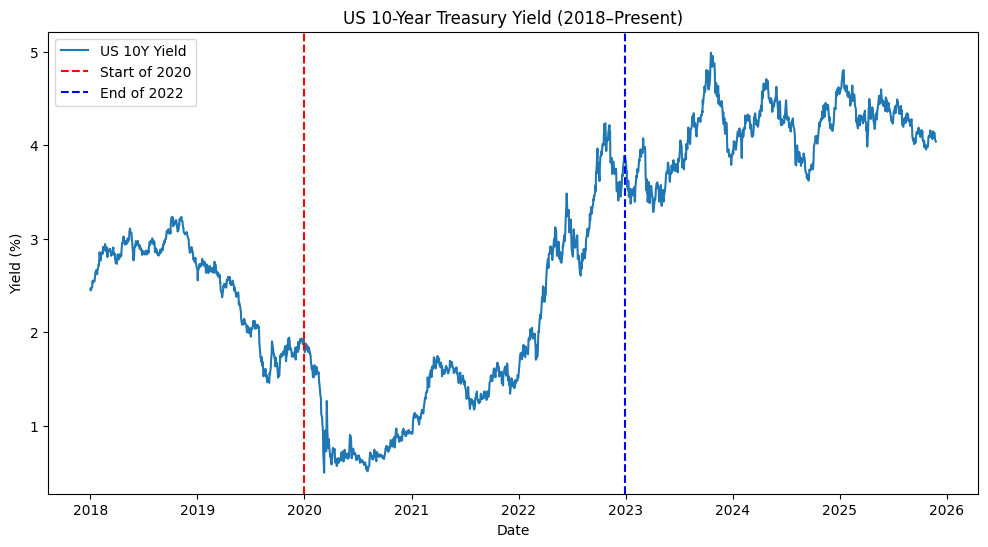

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(yields, label="US 10Y Yield")
plt.title("US 10-Year Treasury Yield (2018–Present)")
plt.xlabel("Date")
plt.ylabel("Yield (%)")

# Add vertical lines
plt.axvline(x=pd.to_datetime("2020-01-01"), color="red", linestyle="--", label="Start of 2020")
plt.axvline(x=pd.to_datetime("2022-12-31"), color="blue", linestyle="--", label="End of 2022")

plt.legend()
plt.show()

In the graph, the phenomenon of “flight to quality” can be observed. When the Covid‑19 pandemic hit, demand for fixed‑income assets surged, driving yields sharply lower. As markets stabilized in 2022, capital flowed back into equities, while aggressive Federal Reserve rate hikes sought to curb what was initially described as “transitory” inflation. Yet inflation proved more persistent, and yields have since traded in the 4% range, reflecting the new interest rate environment

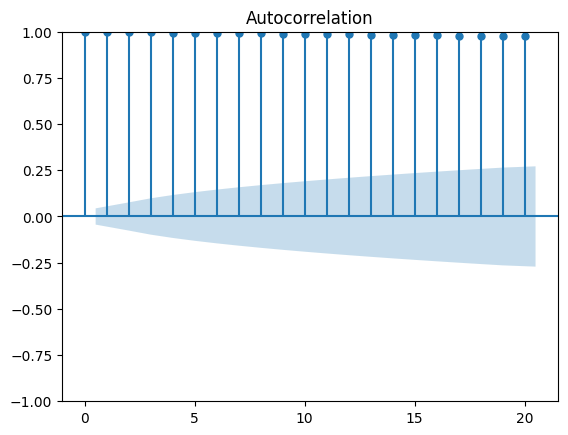

ADF Statistic: -0.7402280487115125
p-value: 0.8360526535803444


In [ ]:
# 4. Autocorrelation function (ACF)
sm.graphics.tsa.plot_acf(yields, lags=20)
plt.show()

# 5. Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(yields.dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

Autocorrelation suggests that yield is related to its past values, as ACF graph is almost 1 for each lag upto 20.  This indicates high persistence in the yield levels.
ADF null hypothesis is non-stationarity can not be rejected, as p-value is higher than 0.05.Thus, suggesting yield level has time dependent mean and variance.


# Using MLP to predict the level of time series

In [ ]:
# Create lagged features (e.g., past 5 days)
def create_lagged_features(series, lags=5):
    df = pd.DataFrame()
    for i in range(1, lags + 1):
        df[f'lag_{i}'] = series.shift(i)
    df['target'] = series
    return df.dropna()

lagged_df = create_lagged_features(yields, lags=5)

lagged_df

,lag_1,lag_2,lag_3,lag_4,lag_5,target
Date,,,,,,
2018-01-09,2.480,2.476,2.453,2.447,2.465,2.546
2018-01-10,2.546,2.480,2.476,2.453,2.447,2.550
2018-01-11,2.550,2.546,2.480,2.476,2.453,2.531
2018-01-12,2.531,2.550,2.546,2.480,2.476,2.552
2018-01-16,2.552,2.531,2.550,2.546,2.480,2.544
...,...,...,...,...,...,...
2025-11-18,4.133,4.148,4.112,4.065,4.120,4.123
2025-11-19,4.123,4.133,4.148,4.112,4.065,4.133
2025-11-20,4.133,4.123,4.133,4.148,4.112,4.106


In [ ]:

# Split into features and target
X = lagged_df.drop(columns='target')
y = lagged_df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
def build_model(hp):
    model = keras.Sequential()

    # Input layer (adjust shape to match your lagged features)
    n_lags = 5
    model.add(keras.layers.Input(shape=(n_lags,)))

    # Hyperparameter search for number of hidden layers
    num_layers = hp.Int('num_layers', min_value=5, max_value=60, step=5)
    units = hp.Int('units', min_value=8, max_value=64, step=8)

    for i in range(num_layers):
        model.add(keras.layers.Dense(units=units, activation='relu'))

    # Output layer
    model.add(keras.layers.Dense(units=1))

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )

    return model

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,    # run each trial once
    directory='mlp_tuner',
    project_name='us10y_yield_new'
)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(
    X_train_scaled, y_train,
    epochs=15,                 # fewer epochs during search
    batch_size=64,             # larger batch size
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stop]
)

best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best number of hidden layers:", best_hps.get('num_layers'))
print("Best units per layer:", best_hps.get('units'))

Trial 5 Complete [00h 00m 26s]
val_loss: 0.0048743970692157745

Best val_loss So Far: 0.003588762367144227
Total elapsed time: 00h 01m 44s
Best number of hidden layers: 50
Best units per layer: 48


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 206 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 48)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 48)             │         2,35

 Total params: 115,585 (451.50 KB)

 Trainable params: 115,585 (451.50 KB)

 Non-trainable params: 0 (0.00 B)

The best model is extremely deep: 50 layers × 48 neurons = 2,400 hidden neurons total.
Trainable parameters: 115,585. For ~2,000 yield observations, this is likely over‑parameterized. The tuner picked it because it minimized validation loss in the short run, but such a deep network may overfit or be inefficient.

Let us train our model little longer


In [ ]:
history = best_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stop]
)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - loss: 2.3336 - mean_absolute_error: 1.0962 - val_loss: 0.0106 - val_mean_absolute_error: 0.0861
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3056 - mean_absolute_error: 0.4770 - val_loss: 0.0099 - val_mean_absolute_error: 0.0821
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0899 - mean_absolute_error: 0.2383 - val_loss: 0.0100 - val_mean_absolute_error: 0.0832
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0752 - mean_absolute_error: 0.2012 - val_loss: 0.0058 - val_mean_absolute_error: 0.0605
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0540 - mean_absolute_error: 0.1664 - val_loss: 0.0145 - val_mean_absolute_error: 0.0999
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0186 - mean_absolute_error: 0.1023 - val_loss: 0.0154 - val_mean_absolute_error: 0.1037
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0121 - mean_absolute_error: 0.0831 - 

In [ ]:
for layer in best_model.layers:
    if isinstance(layer, keras.layers.Dense):
        print(f"Layer: {layer.name}, Units: {layer.units}")

Layer: dense, Units: 48
Layer: dense_1, Units: 48
Layer: dense_2, Units: 48
Layer: dense_3, Units: 48
Layer: dense_4, Units: 48
Layer: dense_5, Units: 48
Layer: dense_6, Units: 48
Layer: dense_7, Units: 48
Layer: dense_8, Units: 48
Layer: dense_9, Units: 48
Layer: dense_10, Units: 48
Layer: dense_11, Units: 48
Layer: dense_12, Units: 48
Layer: dense_13, Units: 48
Layer: dense_14, Units: 48
Layer: dense_15, Units: 48
Layer: dense_16, Units: 48
Layer: dense_17, Units: 48
Layer: dense_18, Units: 48
Layer: dense_19, Units: 48
Layer: dense_20, Units: 48
Layer: dense_21, Units: 48
Layer: dense_22, Units: 48
Layer: dense_23, Units: 48
Layer: dense_24, Units: 48
Layer: dense_25, Units: 48
Layer: dense_26, Units: 48
Layer: dense_27, Units: 48
Layer: dense_28, Units: 48
Layer: dense_29, Units: 48
Layer: dense_30, Units: 48
Layer: dense_31, Units: 48
Layer: dense_32, Units: 48
Layer: dense_33, Units: 48
Layer: dense_34, Units: 48
Layer: dense_35, Units: 48
Layer: dense_36, Units: 48
Layer: dense_

We are confirmed that, even after training our model little longer, we got hidden layers as 50 and number of units as 48. Thus we will predict using these numbers.

In [ ]:
# 50 hidden layers, each with 48 units
mlp = MLPRegressor(
    hidden_layer_sizes=(48,) * 50,   # repeat 48 fifty times
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)
mlp.fit(X_train_scaled, y_train)

MLPRegressor(hidden_layer_sizes=(48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
                                 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
                                 48, 48, 48, 48, 48, 48, ...),
             max_iter=1000, random_state=42)

In [ ]:
# Evaluate
y_pred = mlp.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", rmse)

Test RMSE: 1.7868792441207852


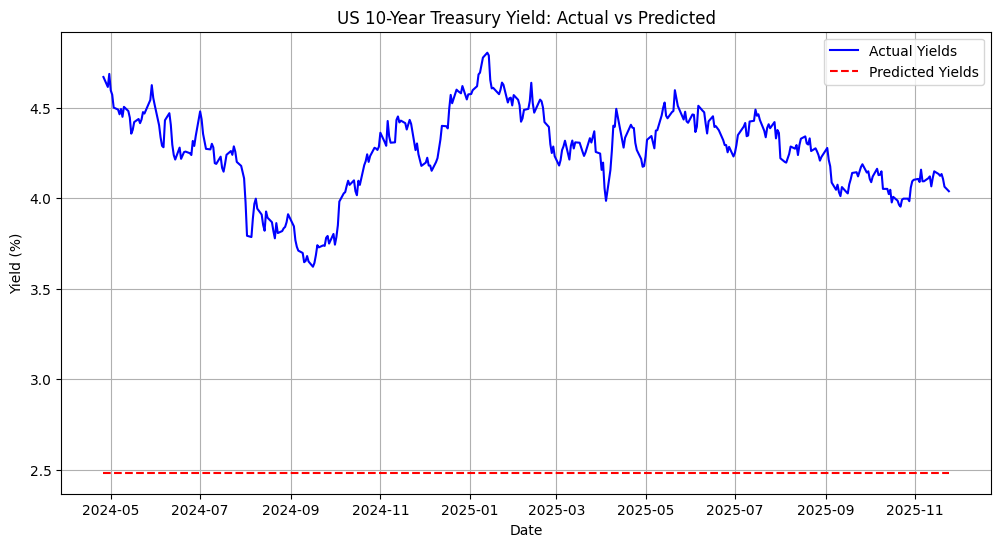

In [ ]:

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual Yields', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Yields', color='red', linestyle='--')

plt.title("US 10-Year Treasury Yield: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.legend()
plt.grid(True)
plt.show()

MLP is predicting flat 2.5%, which could be because of several reasons
1. Due to deep network (50*48), making model to not converge.
2. Vanishing Gradient, activation function 'ReLU' suffer from vanishing gradient with no batch normalization.

In [ ]:
#Let us check for issue 1: Convregence
print("Converged:", mlp.n_iter_ < mlp.max_iter)

Converged: True


In [ ]:
# Rebuild best model from hyperparameters
best_model = tuner.hypermodel.build(best_hps)
optimizer = keras.optimizers.Adam()
loss_fn = keras.losses.MeanSquaredError()

# Create dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train)).batch(64)

# Train for a few epochs and log gradients
for epoch in range(3):  # just a few epochs for inspection
    print(f"\nEpoch {epoch+1}")
    for step, (x_batch, y_batch) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            y_pred = best_model(x_batch, training=True)
            loss = loss_fn(y_batch, y_pred)
        grads = tape.gradient(loss, best_model.trainable_weights)

        # Log gradient stats
        for i, grad in enumerate(grads):
            if grad is not None:
                mean_val = tf.reduce_mean(grad).numpy()
                std_val = tf.math.reduce_std(grad).numpy()
                print(f"Layer {i}: mean={mean_val:.6f}, std={std_val:.6f}")

        optimizer.apply_gradients(zip(grads, best_model.trainable_weights))

If you observe closely you will see that early layers, the mean and standard deviation is close to 0.0000, that means vanishing gradient is the major issue.

Let us correct for vanishing gradient by reducing depth, ie., lower number of hidden layers and by fixing number of units to 15.

In [ ]:
def build_model_new(hp):
    model = keras.Sequential()

    # Input layer (adjust shape to match your lagged features)
    n_lags = 5
    model.add(keras.layers.Input(shape=(n_lags,)))

    # Hyperparameter search for number of hidden layers
    num_layers = hp.Int('num_layers', min_value=1, max_value=10, step=5)
    #units = hp.Int('units', min_value=8, max_value=64, step=8)

    for i in range(num_layers):
        model.add(keras.layers.Dense(units=15, activation='relu')) ## fixing number of units to 15

    # Output layer
    model.add(keras.layers.Dense(units=1))

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )

    return model

In [ ]:
tuner = kt.RandomSearch(
    build_model_new,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,    # run each trial once
    directory='mlp_tuner',
    project_name='us10y_yield_reducelayers'
)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(
    X_train_scaled, y_train,
    epochs=15,                 # fewer epochs during search
    batch_size=64,             # larger batch size
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stop]
)

best_model = tuner.get_best_models(num_models=1)[0]
#best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best number of hidden layers:", best_hps.get('num_layers'))
#print("Best units per layer:", best_hps.get('units'))

Reloading Tuner from mlp_tuner/us10y_yield_reducelayers/tuner0.json
Best number of hidden layers: 6


In [ ]:
# 6 hidden layers, each with 15 units
mlp_new = MLPRegressor(
    hidden_layer_sizes=(15,) * 6,
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)
mlp_new.fit(X_train_scaled, y_train)

MLPRegressor(hidden_layer_sizes=(15, 15, 15, 15, 15, 15), max_iter=1000,
             random_state=42)

In [ ]:
# Evaluate
y_pred_new = mlp_new.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_new))
print("Test RMSE:", rmse)

Test RMSE: 0.08837116442933646


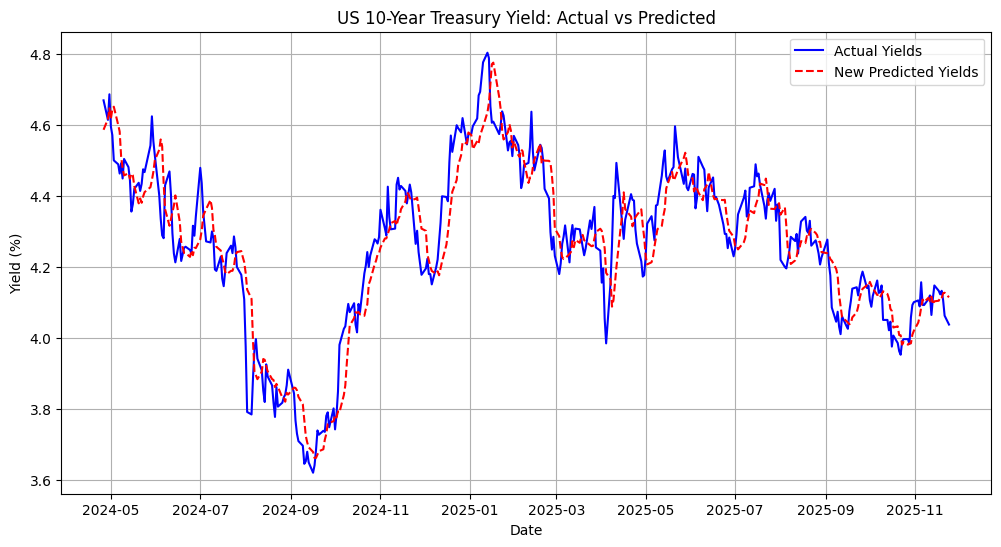

In [ ]:
# Plot actual vs predicted yields
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual Yields', color='blue')
plt.plot(y_test.index, y_pred_new, label='New Predicted Yields', color='red', linestyle='--')

plt.title("US 10-Year Treasury Yield: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.legend()
plt.grid(True)
plt.show()

By reducing the hidden layers, we were able to make the prediction much more reasonable. Further, RMSE decreased from 1.7869 to 0.08837, which is 95% reduction.
Best number of hidden layers = 6 and number of units = 15.